In [5]:
import numpy as np
import chess

def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'

    # Initialize the binary board
    binary_board = np.zeros((768,), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    # Parse the board part of the FEN string
    rows = board_part.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                # Empty squares
                col += int(char)
            else:
                # Piece
                if isWhite:
                    binary_board[(i*8 + col)*12 + pieces[char]] = 1
                else:
                    binary_board[(63-(i*8 + col))*12 + (pieces[char]+6)%12] = 1
                col += 1

    return binary_board


In [6]:
from tensorflow.keras import regularizers, layers
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects

tf.compat.v1.disable_eager_execution()

def squared_clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)**2

get_custom_objects().update({'squared_clipped_relu': squared_clipped_relu})

main_input = tf.keras.Input(shape=(768,), name='main_input')

x = layers.Dense(768, kernel_regularizer=regularizers.l2(0.01), activation="squared_clipped_relu")(main_input)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=main_input, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 768)]             0         
                                                                 
 dense_2 (Dense)             (None, 768)               590592    
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 769       
                                                                 
Total params: 591361 (2.26 MB)
Trainable params: 591361 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
import random
# with open(r'fen_ratingsomate2.txt', 'r') as f:
with open(r'akimbo-2085723380.epd', 'r') as f:
    lines = f.readlines()
    
random.shuffle(lines)
fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [(-float(line.split()[-3]) if line.split()[1] == 'b' else float(line.split()[-3]))/1.0 for line in lines] 

binary_boards = []

for fen in fens:
    binary_board = fen_to_board(fen)
    binary_boards.append(binary_board)

binary_boards = np.array(binary_boards)
ratings = np.array(ratings)


In [9]:
train_size = int(len(binary_boards) * 0.8)
val_size = int(len(binary_boards) * 0.10)

# Separate binary boards and piece amounts
x_binary_train, y_train = binary_boards[:train_size], ratings[:train_size]
x_binary_val, y_val = binary_boards[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, y_test = binary_boards[train_size + val_size:], ratings[train_size + val_size:]


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_binary_train,
    y_train,
    validation_data=(x_binary_val, y_val),
    batch_size=64,
    epochs=7,  
    callbacks=[early_stopping]
)


Train on 2273917 samples, validate on 284239 samples
Epoch 1/7


2273917/2273917 [==============================] - 297s 131us/sample - loss: 54835.3600 - mae: 174.8401 - val_loss: 47711.2977 - val_mae: 159.8549
Epoch 2/7
2273917/2273917 [==============================] - 277s 122us/sample - loss: 51919.4494 - mae: 169.2525 - val_loss: 45162.6122 - val_mae: 154.3501
Epoch 3/7
2273917/2273917 [==============================] - 253s 111us/sample - loss: 50276.3729 - mae: 165.8510 - val_loss: 43853.7212 - val_mae: 151.2459
Epoch 4/7
2273917/2273917 [==============================] - 240s 106us/sample - loss: 49132.3803 - mae: 163.4543 - val_loss: 42746.0807 - val_mae: 148.6938
Epoch 5/7
2273917/2273917 [==============================] - 247s 109us/sample - loss: 48272.1511 - mae: 161.5537 - val_loss: 41946.5895 - val_mae: 146.5566
Epoch 6/7
2273917/2273917 [==============================] - 268s 118us/sample - loss: 47521.2696 - mae: 159.8044 - val_loss: 41174.9182 - val_mae: 144.6781
Epoch 7/7
2273917/2273917 [==============================] - 266s 11

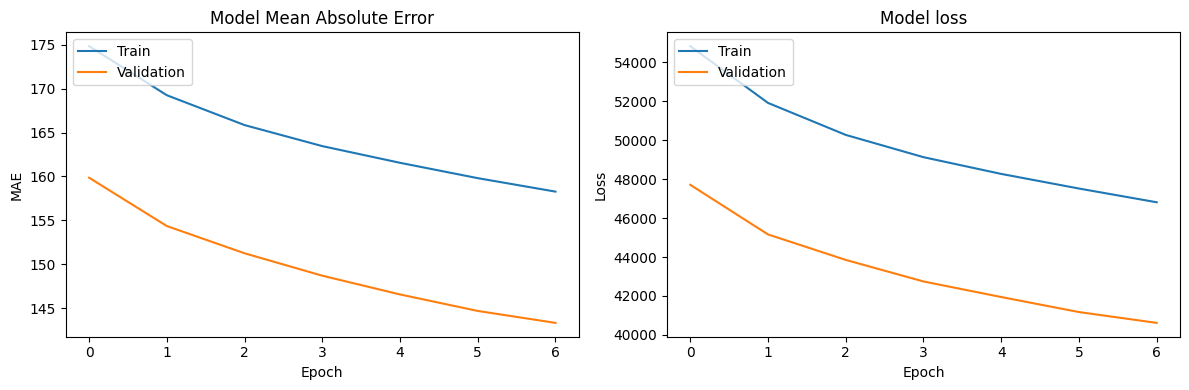

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
model.save_weights('TrainedModel4.keras')

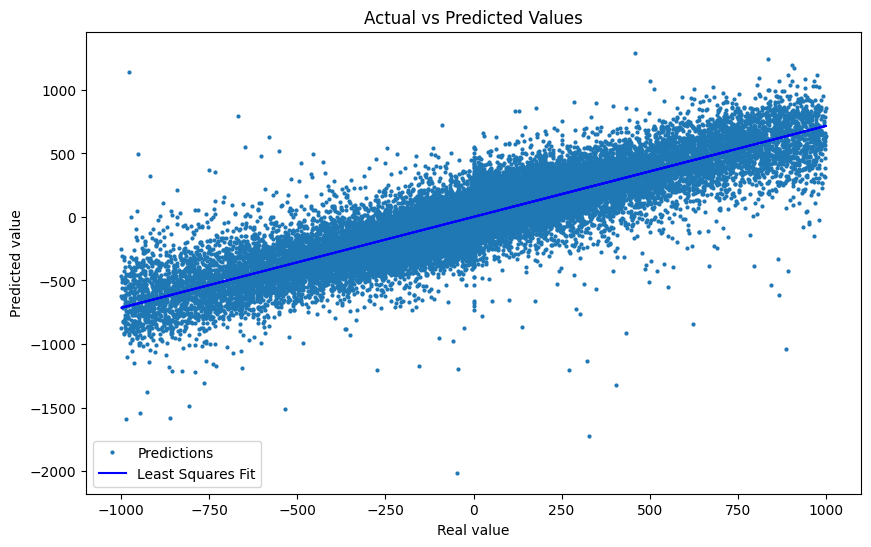

Predicted rating: [603.7295], True rating: 725.0
Predicted rating: [-165.10825], True rating: -145.0
Predicted rating: [-34.1864], True rating: -127.0
Predicted rating: [219.64871], True rating: 941.0
Predicted rating: [279.97726], True rating: 348.0
Predicted rating: [-165.18687], True rating: -59.0
Predicted rating: [481.07867], True rating: 693.0
Predicted rating: [-242.29662], True rating: 99.0
Predicted rating: [-250.74565], True rating: -308.0
Predicted rating: [-445.30515], True rating: -735.0
Predicted rating: [97.08337], True rating: 179.0
Predicted rating: [-277.76938], True rating: -606.0
Predicted rating: [-451.83652], True rating: -195.0
Predicted rating: [193.49355], True rating: 193.0
Predicted rating: [-115.92293], True rating: -394.0
Predicted rating: [16.766335], True rating: -80.0
Predicted rating: [-160.00148], True rating: -319.0
Predicted rating: [-39.2154], True rating: 105.0
Predicted rating: [516.566], True rating: 543.0
Predicted rating: [524.3691], True ratin

In [19]:
def squared_clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)**2

from tensorflow.keras.models import load_model

# tf.compat.v1.disable_eager_execution()
# get_custom_objects().update({'squared_clipped_relu': squared_clipped_relu})
# model = load_model(r"TrainedModel.keras")

import matplotlib.pyplot as plt
import numpy as np

x_test = x_binary_test[:30000]
# Predict the ratings for the test data
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test[:30000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')


# Least squares fit line
coeff = np.polyfit(y_test[:30000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:30000].flatten())
plt.plot(y_test[:30000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")